# Thermal fin digital twin simulator

This notebook demonstrates a digital twin under time-varying heat fluxes. The simulation steps are:
1. True heat flux of physical thermal fin changes over time
    * Since we do not have an actual physical system, the physical model is simulated using finite element(FE) model
2. Get sensor measurement from physical model
2. Error-aware Reduced Basis (RB)-based digital twin model inversely identifies the heat flux from sensor data
3. We monitor the temperature field based on identified heat flux using FE model
4. Control actions are applied when temperature thresholds are exceeded and the corresponding temperature field is visualized using FE model

The output is an animated GIF.

In [100]:
import sys, os
import shutil
os.chdir("/home/shared")
sys.path.append("./src")
sys.path.append("./src/kriging")

# clear RBniCS cache to start fresh
RBNICS_CACHE = "/home/shared/Subfin_NO_GEOMETRY_PARAM"
if os.path.exists(RBNICS_CACHE):
    shutil.rmtree(RBNICS_CACHE)

from dolfin import *
from rbnics import *

In [101]:
import time
import importlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

import inverse_id
importlib.reload(inverse_id)
from inverse_id import sensor_output, reset_cache
from kriging import Kriging
import simulator
importlib.reload(simulator)
from simulator import DTwinSimulator

## 1. Define Finite Element (FE) model

In [102]:
class Subfin(EllipticCoerciveProblem):
    def __init__(self, V, **kwargs):
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains = kwargs["subdomains"]
        self.boundaries = kwargs["boundaries"]

        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    def name(self):
        return "Subfin_NO_GEOMETRY_PARAM"

    def compute_theta(self, term): # define physical parameters
        mu = self.mu

        if term == "a":
            theta_a0 = 1.0   # primary fin conductivity
            theta_a1 = 0.9 # subfin conductivity
            theta_a2 = mu[0] # primary fin Biot
            theta_a3 = mu[1] # subfin Biot
            return (theta_a0, theta_a1, theta_a2, theta_a3)

        elif term == "f":
            # heat flux q
            theta_f0 = mu[2] 
            return (theta_f0,)

        else:
            raise ValueError("Invalid term for compute_theta().")

    def assemble_operator(self, term):
        u = self.u
        v = self.v
        dx = self.dx
        ds = self.ds

        if term == "a":
            # primary fin
            a0 = inner(grad(u),grad(v))*dx(1)+inner(grad(u),grad(v))*dx(2)+inner(grad(u),grad(v))*dx(3)+inner(grad(u),grad(v))*dx(4)
            a1 = inner(grad(u),grad(v))*dx(5)+inner(grad(u),grad(v))*dx(6)+inner(grad(u),grad(v))*dx(7)+inner(grad(u),grad(v))*dx(8)
            a2 = inner(u,v)*ds(2)+inner(u,v)*ds(6)+inner(u,v)*ds(10)
            a3 = inner(u,v)*ds(1)+inner(u,v)*ds(3)+inner(u,v)*ds(4)+inner(u,v)*ds(5)+inner(u,v)*ds(7)+inner(u,v)*ds(8)+inner(u,v)*ds(9)
            return (a0, a1, a2, a3)

        elif term == "f":
            # heat flux
            f0 = v * ds(1)
            return (f0,)

        elif term == "inner_product":
            x0 = inner(grad(u), grad(v)) * dx + inner(u, v) * dx
            return (x0,)

        else:
            raise ValueError("Invalid term for assemble_operator().")


In [103]:
mesh = Mesh("RBniCS/tutorials/21_thermal_subfin/data/subfin1.xml")
subdomains = MeshFunction("size_t", mesh, "RBniCS/tutorials/21_thermal_subfin/data/subfin1_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "RBniCS/tutorials/21_thermal_subfin/data/subfin1_facet_region.xml")
V = FunctionSpace(mesh, "Lagrange", 2)

## 2. Build Reduced Basis (RB) model

In [104]:
problem = Subfin(V, subdomains=subdomains, boundaries=boundaries) # create problem instance
# define parameter ranges
mu_range = [ 
    (0.1, 5),
    (0.1, 3),
    (0.1, 10)
]
problem.set_mu_range(mu_range)
mu = (2, 1, 8)

# training set up for reduced basis model
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(50)
reduction_method.set_tolerance(1e-6)
reduction_method.initialize_training_set(50)

# train and save RB model
reduced_problem = reduction_method.offline()

# define FE model instance
truth_problem = reduced_problem.truth_problem

=          Subfin_NO_GEOMETRY_PARAM POD-Galerkin offline phase begins          =

###################################### 0 #######################################
truth solve for mu = (1.0186440919433273, 1.938961653638846, 9.755017939235127)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (3.7206947381384072, 0.20689140508769244, 4.847653117044088)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (0.5179451421535226, 1.3709064605513195, 9.189434336402142)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (2.5083522524319823, 0.948461848963012, 8.804104319360116)
update snapshots matrix

###################################### 4 #######################################
truth solve for mu = (2.2678608658936192, 0.1669767390822325, 4.210420833090183)
update sn

## 3. Train Kriging Error Model

In [105]:
# define sensor location
sensor_loc = [448]

# generate training data for Kriging error model
x_Bi1 = np.linspace(0.1, 5.0, 3)
x_Bi2 = np.linspace(0.1, 3.0, 3)
x_q = np.linspace(0.1, 10.0, 3)

mu_train = []
for i in x_Bi1:
    for j in x_Bi2:
        for k in x_q:
            mu_train.append([i, j, k])
mu_train = np.array(mu_train)

X = []
Y = []
stime = time.time()
for idx, mu in enumerate(mu_train):
    # run FE
    reset_cache(truth_problem)
    truth_problem.set_mu(tuple(mu))
    u_fe = truth_problem.solve()
    y_fe = sensor_output(u_fe, sensor_loc)

    # run RB
    reduced_problem.set_mu(tuple(mu))
    u_rb_coeff = reduced_problem.solve()
    u_rb = reduced_problem.basis_functions * u_rb_coeff
    y_rb = sensor_output(u_rb, sensor_loc)

    # compute error
    err = np.linalg.norm(y_fe - y_rb)
    X.append(mu)
    Y.append(err)
etime = time.time()
print('Training data generation time:', etime - stime)

X_train = np.array(X) # (N, 3)
Y_train = np.array(Y).reshape(-1,1)  # (N, 1)

Training data generation time: 5.071917533874512


In [106]:
# train Kriging model to predict RB error
krg_err = Kriging(
    kernel="ardmatern32",
    regularize=True,
    normalize=True,
    n_restart=5
)
stime = time.time()
krg_err.train(X_train, Y_train)
etime = time.time()
print("Kriging model training time:", etime - stime)

Kriging model training time: 0.5171980857849121


## 4. Run digital twin simulation

In [107]:
# create simulator
simulator = DTwinSimulator(
    truth_problem=truth_problem,
    reduced_problem=reduced_problem,
    kriging_model=krg_err,
    sensor_loc=sensor_loc,
    output_dir="./dtwin_results"
)

In [108]:
# run simulation
# Set compare_fe=True to compare with the FE-based identification.
history = simulator.run_simulation(t_steps=20, compare_fe=True)

Running simulation: 20 steps
------------------------------------------------------------
step 1/20 (t=0.0000s: true q = 2.00)
Identification time using error corrected RB model: 0.12494945526123047
Identification time: 1.6666855812072754
error-aware RB-based twin speedup: 13.338878330623803x faster
Temperature is already low. Reducing cooling.
system parameters after control: [2, 1, 1.9872284454349667]
current maximum temperature: 0.4577942742389251
step 2/20 (t=0.4783s: true q = 2.00)
Identification time using error corrected RB model: 0.12037014961242676
Identification time: 1.6671044826507568
error-aware RB-based twin speedup: 13.849816487049116x faster
Temperature is already low. Reducing cooling.
system parameters after control: [2, 1, 1.9872284454349667]
current maximum temperature: 0.4577942742389251
step 3/20 (t=0.9805s: true q = 10.00)
Identification time using error corrected RB model: 0.12310004234313965
Identification time: 1.6782448291778564
error-aware RB-based twin spee

## 5. Generate GIF

In [109]:
# generate and save gif
gif_path = simulator.save_gif(history)

Frame 1/20
Frame 2/20
Frame 3/20
Frame 4/20
Frame 5/20
Frame 6/20
Frame 7/20
Frame 8/20
Frame 9/20
Frame 10/20
Frame 11/20
Frame 12/20
Frame 13/20
Frame 14/20
Frame 15/20
Frame 16/20
Frame 17/20
Frame 18/20
Frame 19/20
Frame 20/20


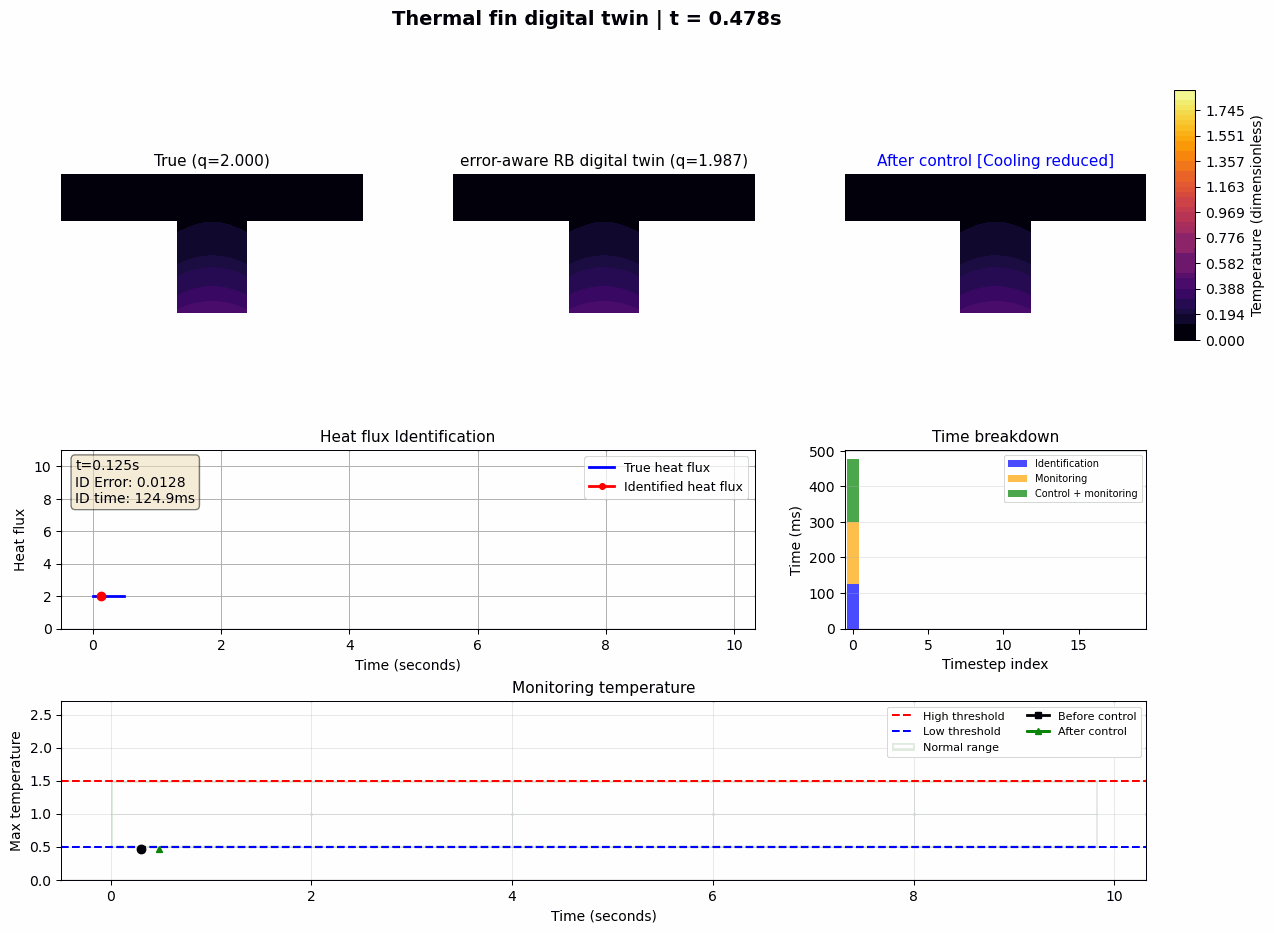

In [110]:
# display gif
display(Image(filename=gif_path))